# Example notebook for different normalization techniques

Normalization methods available in py_neuromodulation are:

  MEAN = "mean"

  MEDIAN = "median"

  ZSCORE = "zscore"

  ZSCORE_MEDIAN = "zscore-median"

  QUANTILE = "quantile"

  POWER = "power"

  ROBUST = "robust"

  MINMAX = "minmax"`

We are going to explore the differences between no normalization, zscoring and quantile normalization.

In pre-processing, raw normalization refers to normalizing the data with respect to the past number of "normalize_samples".

In post-processing, feature normalization refers to normalizing features with respect to the past number of "normalize_samples".

In [1]:
import os
import sys
import py_neuromodulation as nm
import xgboost
from py_neuromodulation import (
    nm_analysis,
    nm_decode,
    nm_define_nmchannels,
    nm_IO,
    nm_plots,
    nm_stats
)
from sklearn import metrics, model_selection
import json
import matplotlib.pyplot as plt
import numpy as np
import re

# change root directory of the project
SCRIPT_DIR = os.path.dirname(os.path.abspath(''))
if SCRIPT_DIR.split("/")[-1] == "py_neuromodulation":
    # this check is necessary, so we can also run the script from the root directory
    SCRIPT_DIR = os.path.join(SCRIPT_DIR, "examples")

sys.path.append(os.path.dirname(SCRIPT_DIR))

# Reload imports to get changes in other scripts
%load_ext autoreload
%autoreload 2

In [2]:
sub = "000"
ses = "right"
task = "force"
run = 3
datatype = "ieeg"

# Define run name and access paths in the BIDS format.
RUN_NAME = f"sub-{sub}_ses-{ses}_task-{task}_run-{run}"

PATH_RUN = os.path.join(
    (os.path.join(SCRIPT_DIR, "data")),
    f"sub-{sub}",
    f"ses-{ses}",
    datatype,
    RUN_NAME,
)
PATH_BIDS = os.path.join(SCRIPT_DIR, "data")


(
    raw,
    data,
    sfreq,
    line_noise,
    coord_list,
    coord_names,
) = nm_IO.read_BIDS_data(
    PATH_RUN=PATH_RUN, BIDS_PATH=PATH_BIDS, datatype=datatype
);

Extracting parameters from /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/sub-000/ses-right/ieeg/sub-000_ses-right_task-force_run-3_ieeg.vhdr...
Setting channel info structure...
Reading channel info from /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/sub-000/ses-right/ieeg/sub-000_ses-right_task-force_run-3_channels.tsv.
Reading electrode coords from /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/sub-000/ses-right/ieeg/sub-000_ses-right_space-mni_electrodes.tsv.


### No Normalization

In [3]:
# Provide a path for the output data. Each re-referencing method has their PATH_OUT
PATH_OUT_NONE = os.path.join(SCRIPT_DIR, "data", "derivatives", "normalization", "none")
nm_channels_None = nm_define_nmchannels.set_channels(
    ch_names=raw.ch_names,
    ch_types=raw.get_channel_types(),
    reference='default',
    bads=raw.info["bads"],
    new_names="default",
    used_types=("dbs", "seeg"), # Focus on LFP data
    target_keywords=("MOV_LEFT_CLEAN",),
)

stream_None = nm.Stream(
    settings=None,
    nm_channels=nm_channels_None,
    path_grids=None,
    verbose=False,
)

stream_None.set_settings_fast_compute()


stream_None.settings['preprocessing']['raw_normalization'] = False
stream_None.settings['postprocessing']['feature_normalization'] = False
stream_None.settings[ "raw_normalization_settings"]["normalization_method"] = {
            "mean": False,
            "median": False,
            "zscore": False,
            "zscore-median": False,
            "quantile": False,
            "power": False,
            "robust": False,
            "minmax": False
        }

stream_None.settings[ "feature_normalization_settings"]["normalization_method"] = {
            "mean": False,
            "median": False,
            "zscore": False,
            "zscore-median": False,
            "quantile": False,
            "power": False,
            "robust": False,
            "minmax": False
        }



stream_None.init_stream(
    sfreq=sfreq,
    line_noise=line_noise,
    coord_list=coord_list,
    coord_names=coord_names
)

stream_None.run(
    data=data,
    out_path_root=PATH_OUT_NONE,
    folder_name=RUN_NAME,
)

No Error occurred when testing the settings.
No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 7.50 Hz
- Upper transition bandwidth: 7.50 Hz
- Filter length: 999 samples (0.999 sec)

_SIDECAR.json saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/normalization/none/sub-000_ses-right_task-force_run-3/sub-000_ses-right_task-force_run-3_SIDECAR.json
FEATURES.csv saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/normalization/none/sub-000_ses-right_task-force_run-3/sub-000_ses-right_task-force_run-3_FEATURES.csv


 ### Zscore
 The normalized array of the current sample subtracts the previous sample mean and divides it by the previous sample standard deviation.
 #### 1. Zscore in pre-processing

In [4]:
# Provide a path for the output data. Each re-referencing method has their PATH_OUT
PATH_OUT_ZSCORE_PRE = os.path.join(SCRIPT_DIR, "data", "derivatives", "normalization", "zscore_pre")
nm_channels_zscorePre = nm_define_nmchannels.set_channels(
    ch_names=raw.ch_names,
    ch_types=raw.get_channel_types(),
    reference='default',
    bads=raw.info["bads"],
    new_names="default",
    used_types=("dbs", "seeg"), # Focus on LFP data
    target_keywords=("MOV_LEFT_CLEAN",),
)

stream_zscorePre = nm.Stream(
    settings=None,
    nm_channels=nm_channels_zscorePre,
    path_grids=None,
    verbose=False,
)

stream_zscorePre.set_settings_fast_compute()


stream_zscorePre.settings['preprocessing']['raw_normalization'] = True
stream_zscorePre.settings['postprocessing']['feature_normalization'] = False
stream_zscorePre.settings[ "raw_normalization_settings"]["normalization_method"] = {
            "mean": False,
            "median": False,
            "zscore": True,
            "zscore-median": False,
            "quantile": False,
            "power": False,
            "robust": False,
            "minmax": False
        }



stream_zscorePre.init_stream(
    sfreq=sfreq,
    line_noise=line_noise,
    coord_list=coord_list,
    coord_names=coord_names
)

stream_zscorePre.run(
    data=data,
    out_path_root=PATH_OUT_ZSCORE_PRE,
    folder_name=RUN_NAME,
)

No Error occurred when testing the settings.
No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 7.50 Hz
- Upper transition bandwidth: 7.50 Hz
- Filter length: 999 samples (0.999 sec)

_SIDECAR.json saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/normalization/zscore_pre/sub-000_ses-right_task-force_run-3/sub-000_ses-right_task-force_run-3_SIDECAR.json
FEATURES.csv saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/normalization/zscore_pre/sub-000_ses-right_task-force_run-3/sub-000_ses-right_task-force_run-3_F

#### 2. Zscore in post-processing

In [5]:
# Provide a path for the output data. Each re-referencing method has their PATH_OUT
PATH_OUT_ZSCORE_POST = os.path.join(SCRIPT_DIR, "data", "derivatives", "normalization", "zscore_post")
nm_channels_zscorePost = nm_define_nmchannels.set_channels(
    ch_names=raw.ch_names,
    ch_types=raw.get_channel_types(),
    reference='default',
    bads=raw.info["bads"],
    new_names="default",
    used_types=("dbs", "seeg"), # Focus on LFP data
    target_keywords=("MOV_LEFT_CLEAN",),
)

stream_zscorePost = nm.Stream(
    settings=None,
    nm_channels=nm_channels_zscorePost,
    path_grids=None,
    verbose=False,
)

stream_zscorePost.set_settings_fast_compute()


stream_zscorePost.settings['preprocessing']['raw_normalization'] = False
stream_zscorePost.settings['postprocessing']['feature_normalization'] = True
stream_zscorePost.settings[ "feature_normalization_settings"]["normalization_method"] = {
            "mean": False,
            "median": False,
            "zscore": True,
            "zscore-median": False,
            "quantile": False,
            "power": False,
            "robust": False,
            "minmax": False
        }


stream_zscorePost.init_stream(
    sfreq=sfreq,
    line_noise=line_noise,
    coord_list=coord_list,
    coord_names=coord_names
)

stream_zscorePost.run(
    data=data,
    out_path_root=PATH_OUT_ZSCORE_POST,
    folder_name=RUN_NAME,
)

No Error occurred when testing the settings.
No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 7.50 Hz
- Upper transition bandwidth: 7.50 Hz
- Filter length: 999 samples (0.999 sec)

_SIDECAR.json saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/normalization/zscore_post/sub-000_ses-right_task-force_run-3/sub-000_ses-right_task-force_run-3_SIDECAR.json
FEATURES.csv saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/normalization/zscore_post/sub-000_ses-right_task-force_run-3/sub-000_ses-right_task-force_run-3

### Quantile in post-processing

Quantile normalization is a technique for making two distributions identical in statistical properties. To quantile-normalize a test distribution to a reference distribution of the same length, sort the test distribution and sort the reference distribution. The highest entry in the test distribution then takes the value of the highest entry in the reference distribution, the next highest entry in the reference distribution, and so on, until the test distribution is a perturbation of the reference distribution. [1]

In [6]:
# Provide a path for the output data. Each re-referencing method has their PATH_OUT
PATH_OUT_QUANTILE_POST = os.path.join(SCRIPT_DIR, "data", "derivatives", "normalization", "quantile_post")
nm_channels_quantilePost = nm_define_nmchannels.set_channels(
    ch_names=raw.ch_names,
    ch_types=raw.get_channel_types(),
    reference='default',
    bads=raw.info["bads"],
    new_names="default",
    used_types=("dbs", "seeg"), # Focus on LFP data
    target_keywords=("MOV_LEFT_CLEAN",),
)

stream_quantilePost = nm.Stream(
    settings=None,
    nm_channels=nm_channels_quantilePost,
    path_grids=None,
    verbose=False,
)

stream_quantilePost.set_settings_fast_compute()


stream_quantilePost.settings['preprocessing']['raw_normalization'] = False
stream_quantilePost.settings['postprocessing']['feature_normalization'] = True
stream_quantilePost.settings[ "feature_normalization_settings"]["normalization_method"] = {
            "mean": False,
            "median": False,
            "zscore": False,
            "zscore-median": False,
            "quantile": True,
            "power": False,
            "robust": False,
            "minmax": False
        }



stream_quantilePost.init_stream(
    sfreq=sfreq,
    line_noise=line_noise,
    coord_list=coord_list,
    coord_names=coord_names
)

stream_quantilePost.run(
    data=data,
    out_path_root=PATH_OUT_QUANTILE_POST,
    folder_name=RUN_NAME,
)

No Error occurred when testing the settings.
No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 7.50 Hz
- Upper transition bandwidth: 7.50 Hz
- Filter length: 999 samples (0.999 sec)

_SIDECAR.json saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/normalization/quantile_post/sub-000_ses-right_task-force_run-3/sub-000_ses-right_task-force_run-3_SIDECAR.json
FEATURES.csv saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/normalization/quantile_post/sub-000_ses-right_task-force_run-3/sub-000_ses-right_task-force_r

### Compare movement aligned feature plot for different normalization schemes

We will use only channel `STN_RIGHT_1`.

Feature epoch average figure saved to: /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/normalization/none/sub-000_ses-right_task-force_run-3/MOV_aligned_features_ch_STN_RIGHT_1_fft.png
Feature epoch average figure saved to: /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/normalization/zscore_pre/sub-000_ses-right_task-force_run-3/MOV_aligned_features_ch_STN_RIGHT_1_fft.png
Feature epoch average figure saved to: /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/normalization/zscore_post/sub-000_ses-right_task-force_run-3/MOV_aligned_features_ch_STN_RIGHT_1_fft.png
Feature epoch average figure saved to: /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/normalization/quantile_post/sub-000_ses-right_task-force_run-3/MOV_aligned_features_ch_STN_RIGHT_1_fft.pn

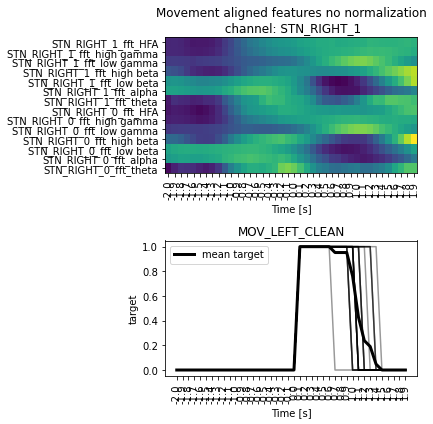

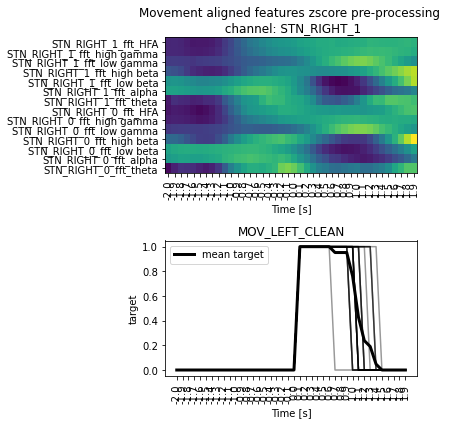

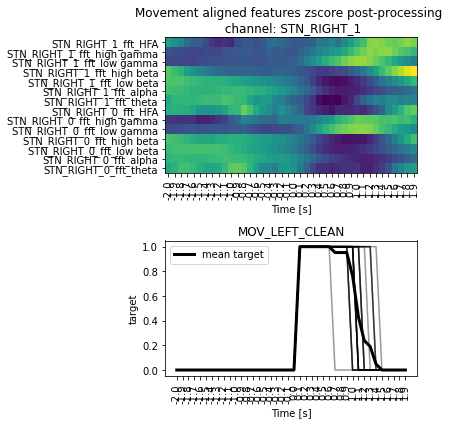

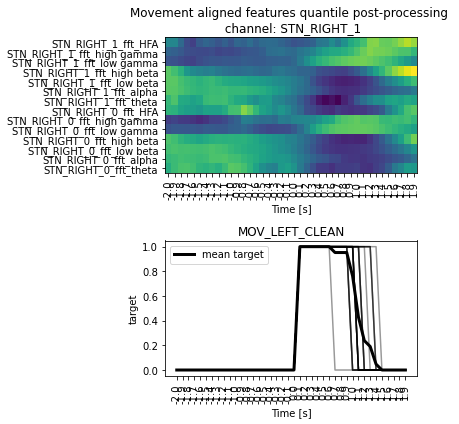

In [7]:
# init analyzer for no normalization
feature_reader_none = nm_analysis.Feature_Reader(
    feature_dir=PATH_OUT_NONE, feature_file=RUN_NAME
)

# plot for a single channel
ch_used_none = "STN_RIGHT_1"

feature_used_none= "fft"

feature_reader_none.plot_target_averaged_channel(
    ch=ch_used_none,
    list_feature_keywords=[feature_used_none],
    epoch_len=4,   # Length of epoch in seconds
    threshold=0.5, # Threshold to be used for identifying events
    show_plot=True,
    title="Movement aligned features no normalization\n"
)
#---------------------------------------
# init analyzer for zscore in pre-processing
feature_reader_zscorePre = nm_analysis.Feature_Reader(
    feature_dir=PATH_OUT_ZSCORE_PRE, feature_file=RUN_NAME
)

# plot for a single channel
ch_used_zscorePre = "STN_RIGHT_1"

feature_used_zscorePre = "fft"

feature_reader_zscorePre.plot_target_averaged_channel(
    ch=ch_used_zscorePre,
    list_feature_keywords=[feature_used_zscorePre],
    epoch_len=4,   # Length of epoch in seconds
    threshold=0.5, # Threshold to be used for identifying events
    show_plot=True,
    title="Movement aligned features zscore pre-processing \n"
)
#--------------------------------------------------
# init analyzer zscore in post-processing
feature_reader_zscorePost = nm_analysis.Feature_Reader(
    feature_dir=PATH_OUT_ZSCORE_POST, feature_file=RUN_NAME
)

# plot for a single channel
ch_used_zscorePost = "STN_RIGHT_1"

feature_used_zscorePost = "fft"

feature_reader_zscorePost.plot_target_averaged_channel(
    ch=ch_used_zscorePost,
    list_feature_keywords=[feature_used_zscorePost],
    epoch_len=4,   # Length of epoch in seconds
    threshold=0.5, # Threshold to be used for identifying events
    show_plot=True,
    title="Movement aligned features zscore post-processing \n"
)

#-----------------------------------------------
# init analyzer quantile in post-processing
feature_reader_quantilePost = nm_analysis.Feature_Reader(
    feature_dir=PATH_OUT_QUANTILE_POST, feature_file=RUN_NAME
)

# plot for a single channel
ch_used_quantilePost = "STN_RIGHT_1"

feature_used_quantilePost = "fft"

feature_reader_quantilePost.plot_target_averaged_channel(
    ch=ch_used_quantilePost,
    list_feature_keywords=[feature_used_quantilePost],
    epoch_len=4,   # Length of epoch in seconds
    threshold=0.5, # Threshold to be used for identifying events
    show_plot=True,
    title="Movement aligned features quantile post-processing \n"
)

### Compare correlation plots

In [8]:
stream_None.nm_channels

,name,rereference,used,target,type,status,new_name
0,STN_RIGHT_0,STN_RIGHT_2,1,0,seeg,good,STN_RIGHT_0-STN_RIGHT_2
1,STN_RIGHT_1,STN_RIGHT_0,1,0,seeg,good,STN_RIGHT_1-STN_RIGHT_0
2,STN_RIGHT_2,STN_RIGHT_1,1,0,seeg,good,STN_RIGHT_2-STN_RIGHT_1
3,ECOG_RIGHT_0,average,0,0,ecog,good,ECOG_RIGHT_0-avgref
4,ECOG_RIGHT_1,average,0,0,ecog,good,ECOG_RIGHT_1-avgref
5,ECOG_RIGHT_2,average,0,0,ecog,good,ECOG_RIGHT_2-avgref
6,ECOG_RIGHT_3,average,0,0,ecog,good,ECOG_RIGHT_3-avgref
7,ECOG_RIGHT_4,average,0,0,ecog,good,ECOG_RIGHT_4-avgref
8,ECOG_RIGHT_5,average,0,0,ecog,good,ECOG_RIGHT_5-avgref
9,MOV_RIGHT,None,0,0,misc,good,MOV_RIGHT


Correlation matrix figure saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/normalization/none/normalization_example_STN_RIGHT_1_none.png


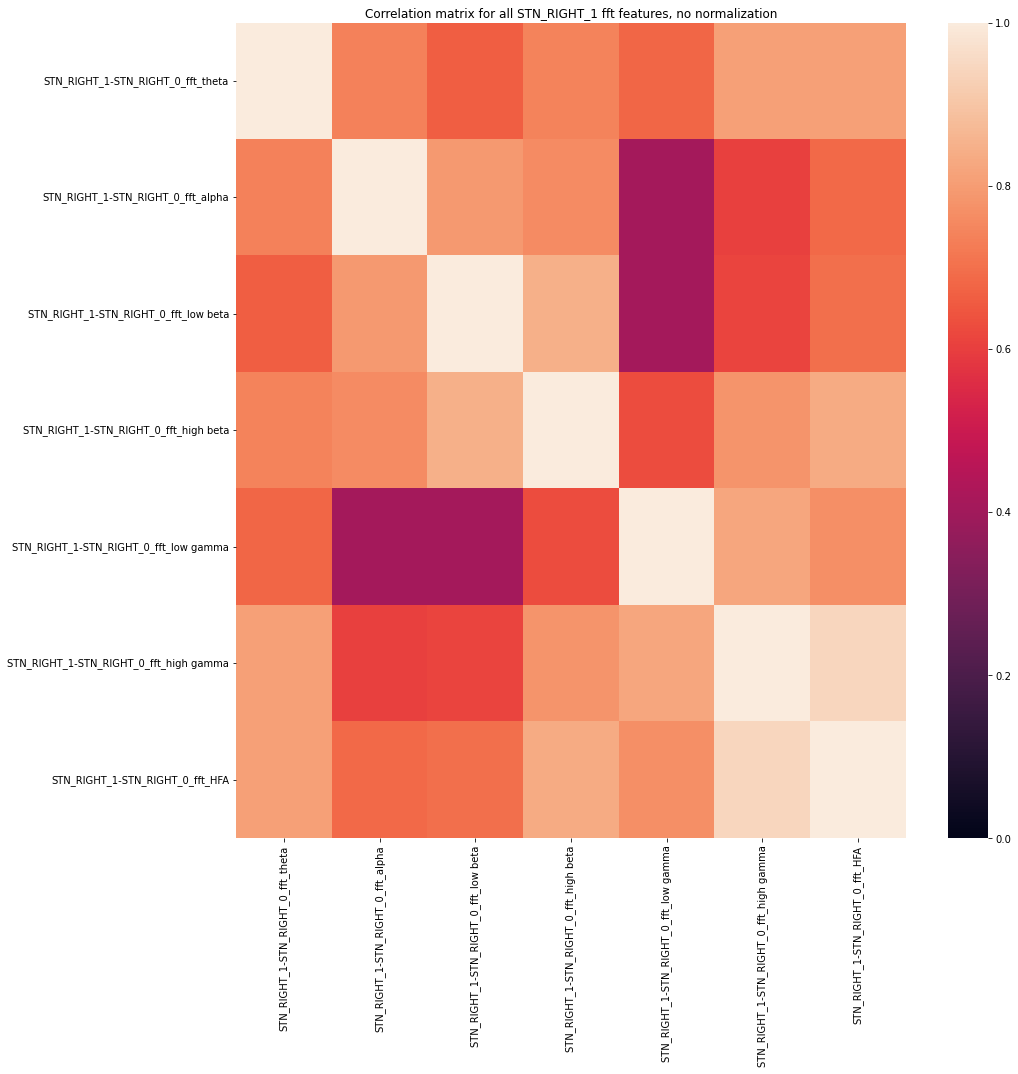

In [9]:
nm_plots.plot_corr_matrix(
        feature = feature_reader_none.feature_arr.filter(regex='STN_RIGHT_1-STN_RIGHT_0'),
        OUT_PATH= PATH_OUT_NONE,
        feature_names=feature_reader_none.feature_arr.filter(regex='STN_RIGHT_1-STN_RIGHT_0').columns,
        feature_file=feature_reader_none.feature_file,
        show_plot=True,
        figsize=(15,15),
        title = "Correlation matrix for all STN_RIGHT_1 fft features, no normalization",
        save_plot_name="normalization_example_STN_RIGHT_1_none.png"
)

Correlation matrix figure saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/normalization/zscore_pre/normalization_example_STN_RIGHT_1_zscore_pre.png


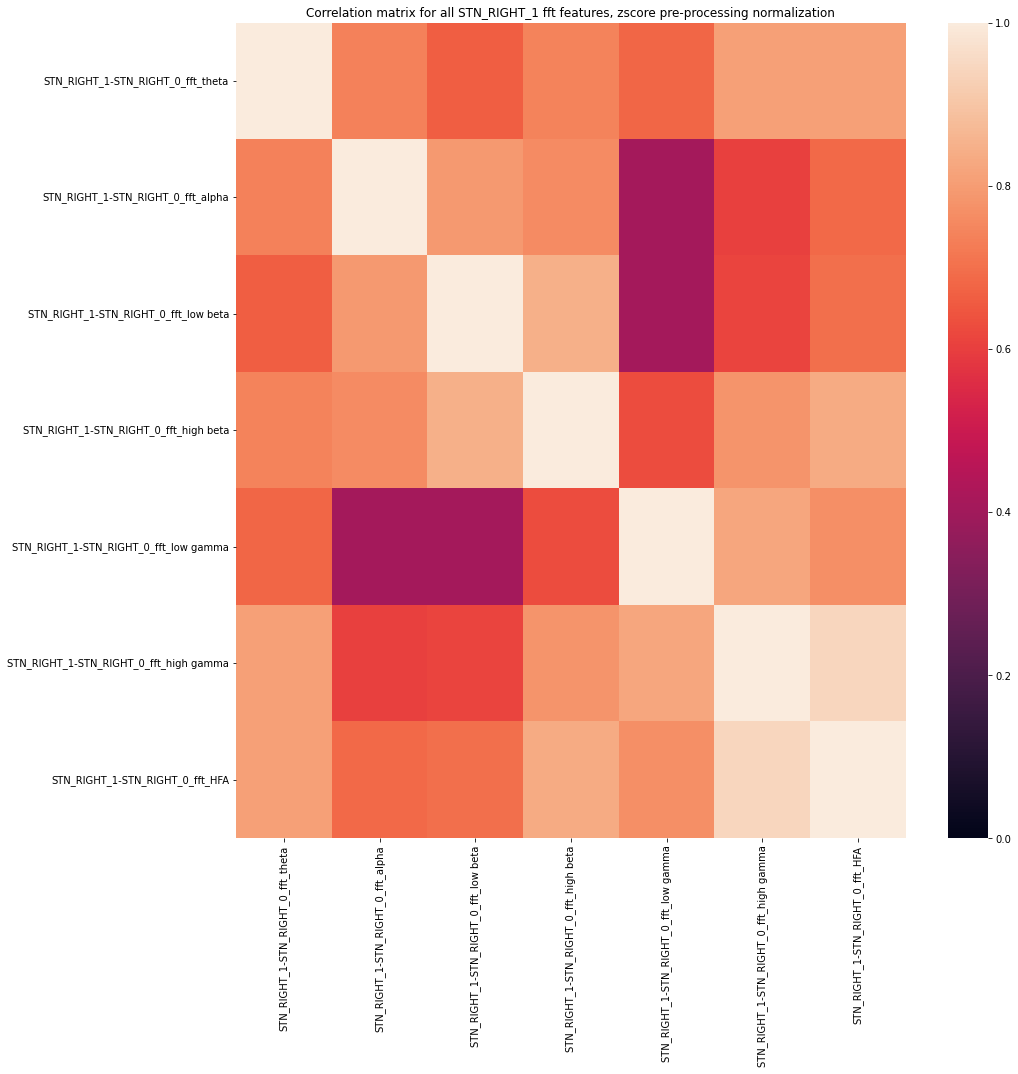

In [10]:
nm_plots.plot_corr_matrix(
        feature = feature_reader_zscorePre.feature_arr.filter(regex='STN_RIGHT_1-STN_RIGHT_0'),
        OUT_PATH= PATH_OUT_ZSCORE_PRE,
        feature_names=feature_reader_zscorePre.feature_arr.filter(regex='STN_RIGHT_1-STN_RIGHT_0').columns,
        feature_file=feature_reader_zscorePre.feature_file,
        show_plot=True,
        figsize=(15,15),
        title = "Correlation matrix for all STN_RIGHT_1 fft features, zscore pre-processing normalization",
        save_plot_name="normalization_example_STN_RIGHT_1_zscore_pre.png"
)

Correlation matrix figure saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/normalization/zscore_post/normalization_example_STN_RIGHT_1_zscore_post.png


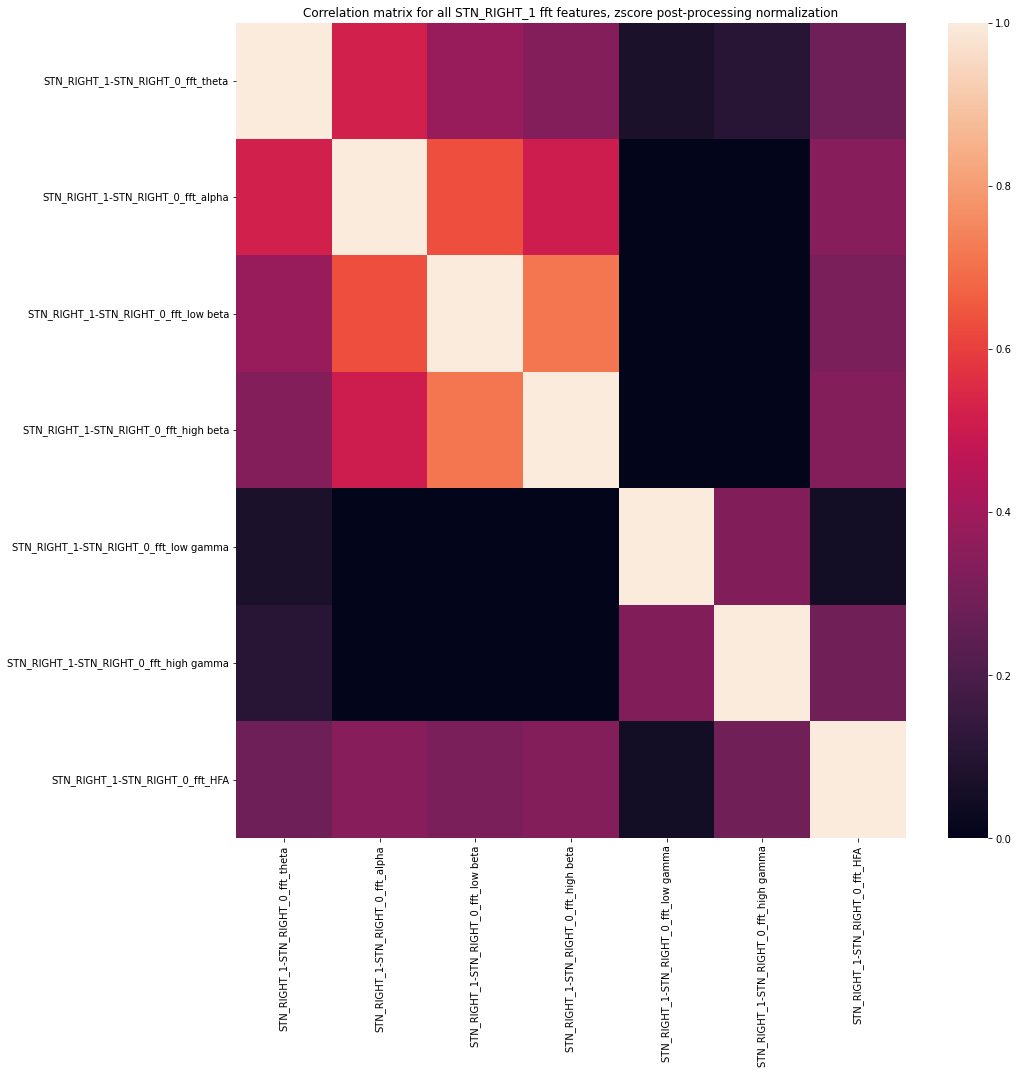

In [11]:
nm_plots.plot_corr_matrix(
        feature = feature_reader_zscorePost.feature_arr.filter(regex='STN_RIGHT_1-STN_RIGHT_0'),
        OUT_PATH= PATH_OUT_ZSCORE_POST,
        feature_names=feature_reader_zscorePost.feature_arr.filter(regex='STN_RIGHT_1-STN_RIGHT_0').columns,
        feature_file=feature_reader_zscorePost.feature_file,
        show_plot=True,
        figsize=(15,15),
        title = "Correlation matrix for all STN_RIGHT_1 fft features, zscore post-processing normalization",
        save_plot_name="normalization_example_STN_RIGHT_1_zscore_post.png"
)

Correlation matrix figure saved to /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/normalization/quantile_post/normalization_example_STN_RIGHT_1_quantile_post.png


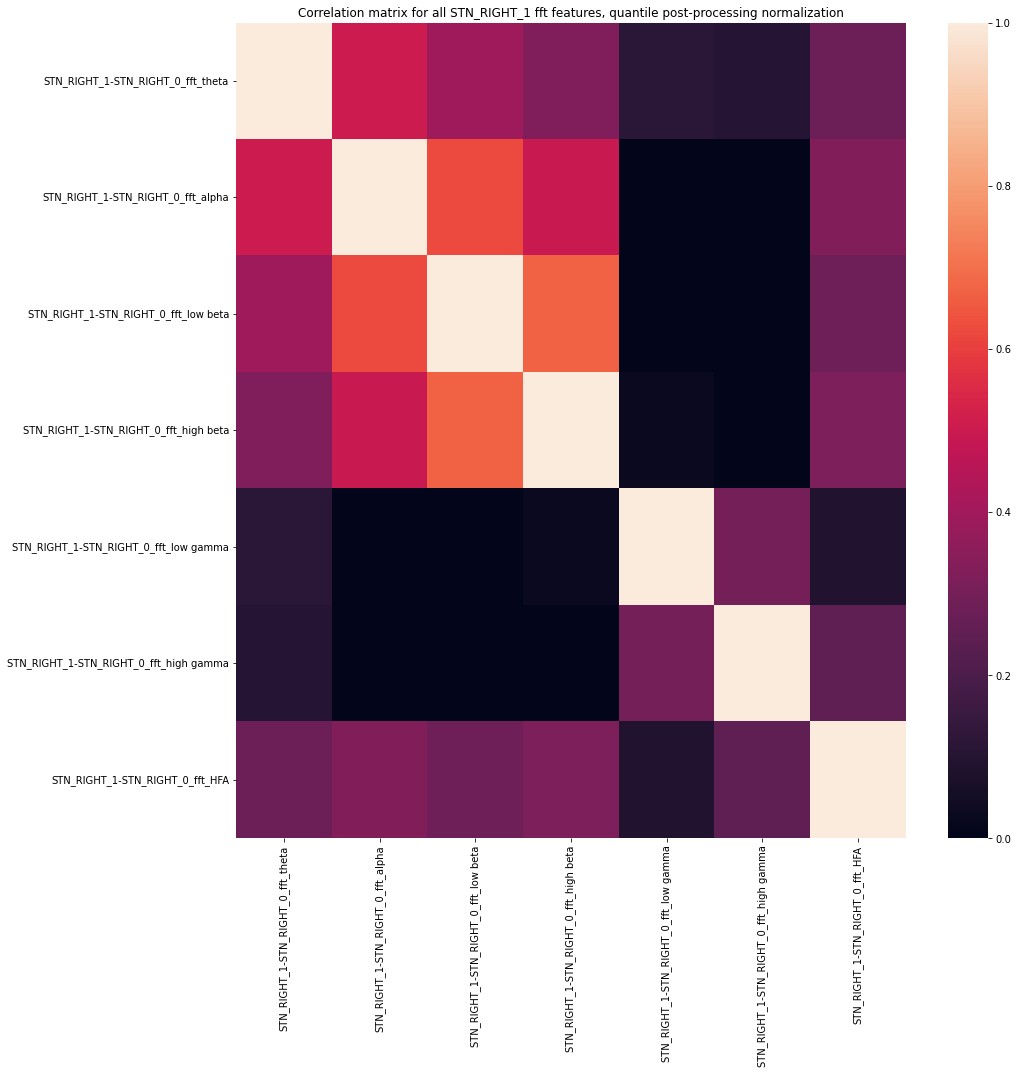

In [12]:
nm_plots.plot_corr_matrix(
        feature = feature_reader_quantilePost.feature_arr.filter(regex='STN_RIGHT_1-STN_RIGHT_0'),
        OUT_PATH= PATH_OUT_QUANTILE_POST,
        feature_names=feature_reader_quantilePost.feature_arr.filter(regex='STN_RIGHT_1-STN_RIGHT_0').columns,
        feature_file=feature_reader_quantilePost.feature_file,
        show_plot=True,
        figsize=(15,15),
        title = "Correlation matrix for all STN_RIGHT_1 fft features, quantile post-processing normalization",
        save_plot_name="normalization_example_STN_RIGHT_1_quantile_post.png"
)

### Compare decoding performance

model being saved to: /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/normalization/zscore_pre/sub-000_ses-right_task-force_run-3/sub-000_ses-right_task-force_run-3_LM_ML_RES.p


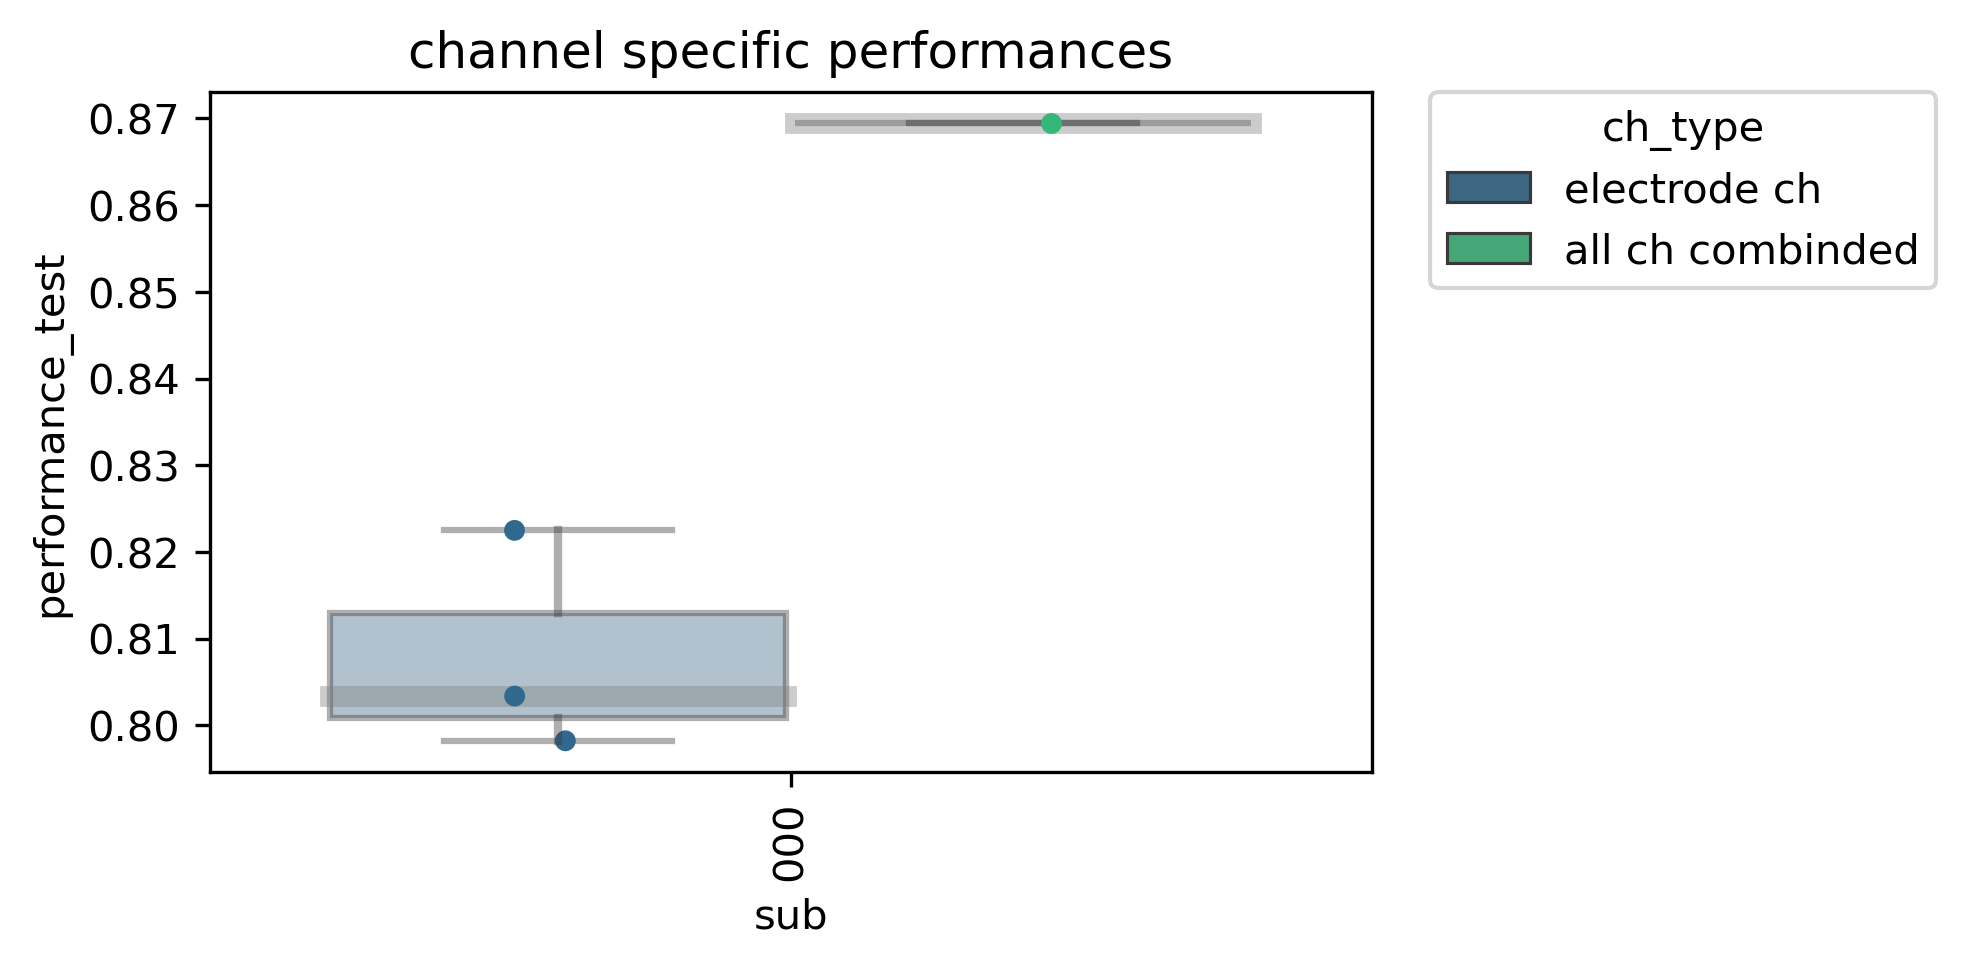

In [13]:
model = xgboost.XGBClassifier(use_label_encoder=False)


feature_reader_zscorePre.decoder = nm_decode.Decoder(
    features=feature_reader_zscorePre.feature_arr,
    label=feature_reader_zscorePre.label,
    label_name=feature_reader_zscorePre.label_name,
    used_chs=feature_reader_zscorePre.used_chs,
    model=model,
    eval_method=metrics.balanced_accuracy_score,
    cv_method=model_selection.KFold(n_splits=3, shuffle=True),
    get_movement_detection_rate=True,
    min_consequent_count=2,
    TRAIN_VAL_SPLIT=False,
    RUN_BAY_OPT=False,
    use_nested_cv=False,
    sfreq=feature_reader_zscorePre.settings["sampling_rate_features_hz"],
)

performances_zscorePre = feature_reader_zscorePre.run_ML_model(
    estimate_channels=True,
    estimate_gridpoints=False,
    estimate_all_channels_combined=True,
    save_results=True,
)

df_per_zscorePre = feature_reader_zscorePre.get_dataframe_performances(performances_zscorePre)

nm_plots.plot_df_subjects(
    df_per_zscorePre, x_col="sub", y_col="performance_test", hue="ch_type",
    PATH_SAVE=os.path.join(PATH_OUT_ZSCORE_PRE, RUN_NAME, RUN_NAME + "_decoding_performance_zscorePre.png")
)

model being saved to: /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/normalization/zscore_post/sub-000_ses-right_task-force_run-3/sub-000_ses-right_task-force_run-3_LM_ML_RES.p


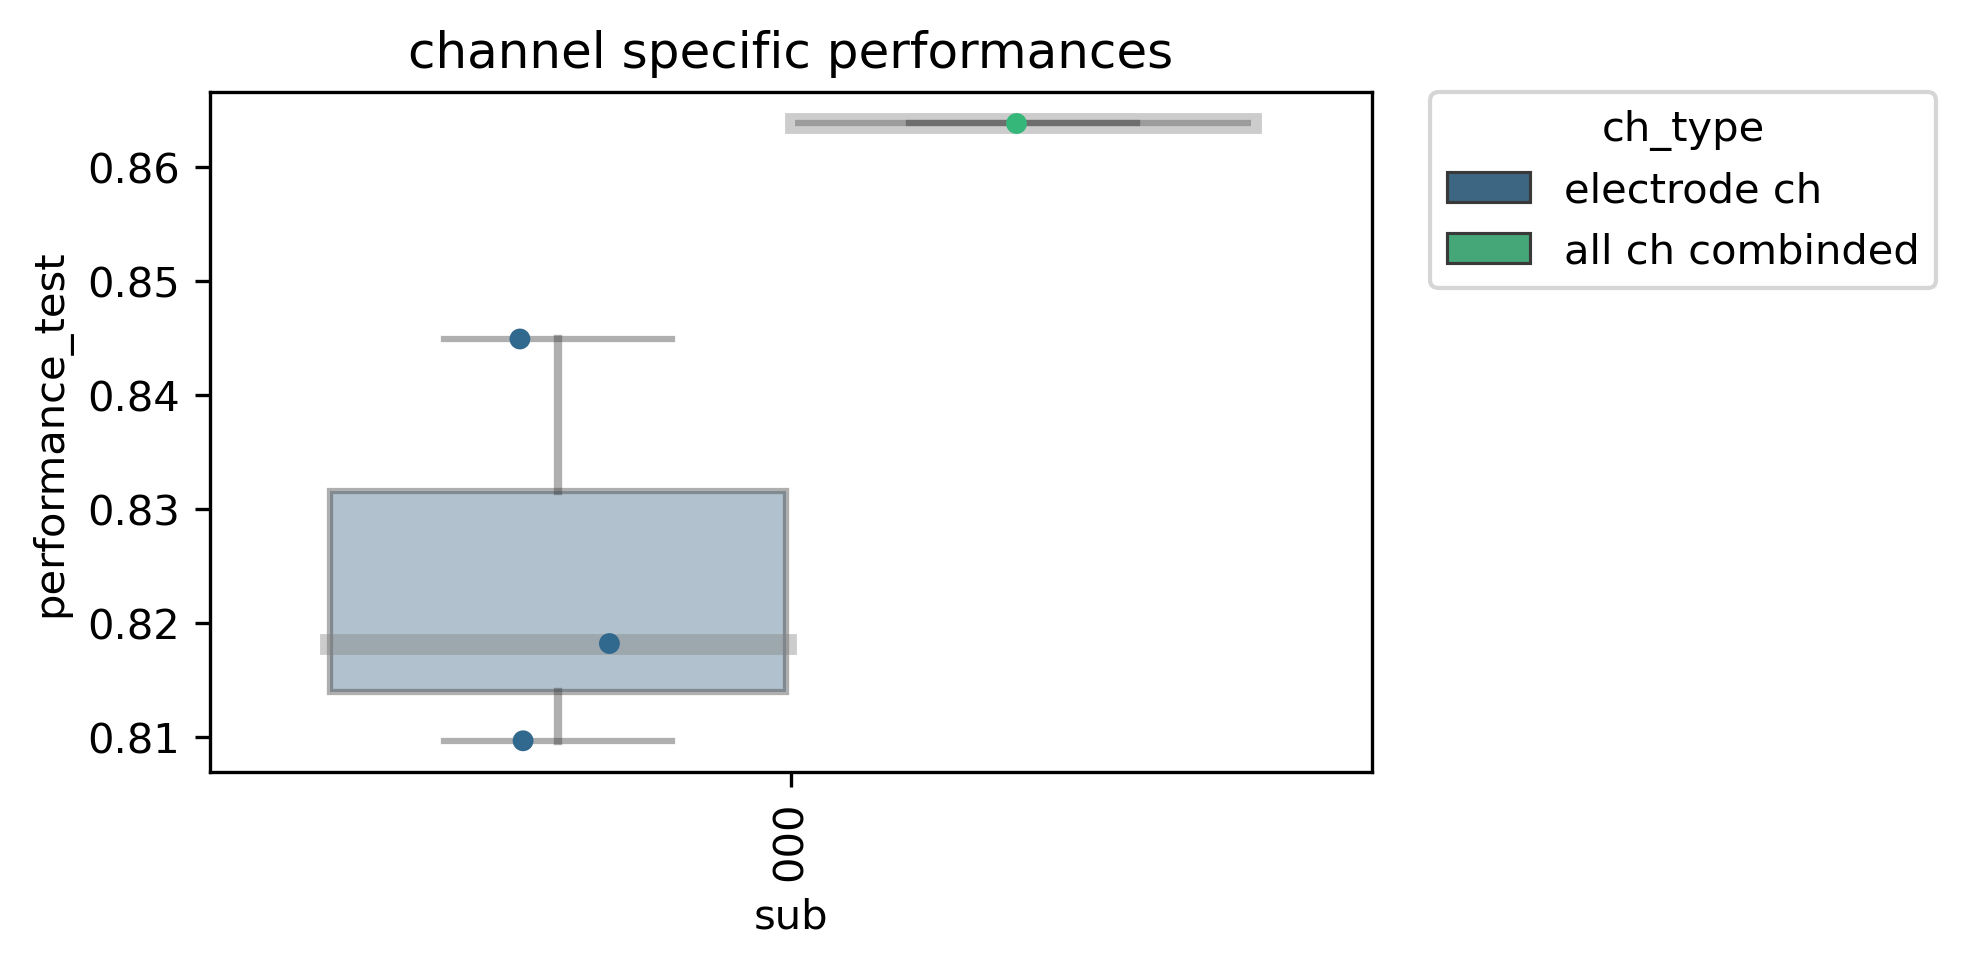

In [14]:
model = xgboost.XGBClassifier(use_label_encoder=False)


feature_reader_zscorePost.decoder = nm_decode.Decoder(
    features=feature_reader_zscorePost.feature_arr,
    label=feature_reader_zscorePost.label,
    label_name=feature_reader_zscorePost.label_name,
    used_chs=feature_reader_zscorePost.used_chs,
    model=model,
    eval_method=metrics.balanced_accuracy_score,
    cv_method=model_selection.KFold(n_splits=3, shuffle=True),
    get_movement_detection_rate=True,
    min_consequent_count=2,
    TRAIN_VAL_SPLIT=False,
    RUN_BAY_OPT=False,
    use_nested_cv=False,
    sfreq=feature_reader_zscorePost.settings["sampling_rate_features_hz"],
)

performances_zscorePost = feature_reader_zscorePost.run_ML_model(
    estimate_channels=True,
    estimate_gridpoints=False,
    estimate_all_channels_combined=True,
    save_results=True,
)

df_per_zscorePost = feature_reader_zscorePost.get_dataframe_performances(performances_zscorePost)

nm_plots.plot_df_subjects(
    df_per_zscorePost, x_col="sub", y_col="performance_test", hue="ch_type",
    PATH_SAVE=os.path.join(PATH_OUT_ZSCORE_POST, RUN_NAME, RUN_NAME + "_decoding_performance_zscorePost.png")
)

model being saved to: /home/lauraflyra/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/examples/data/derivatives/normalization/quantile_post/sub-000_ses-right_task-force_run-3/sub-000_ses-right_task-force_run-3_LM_ML_RES.p


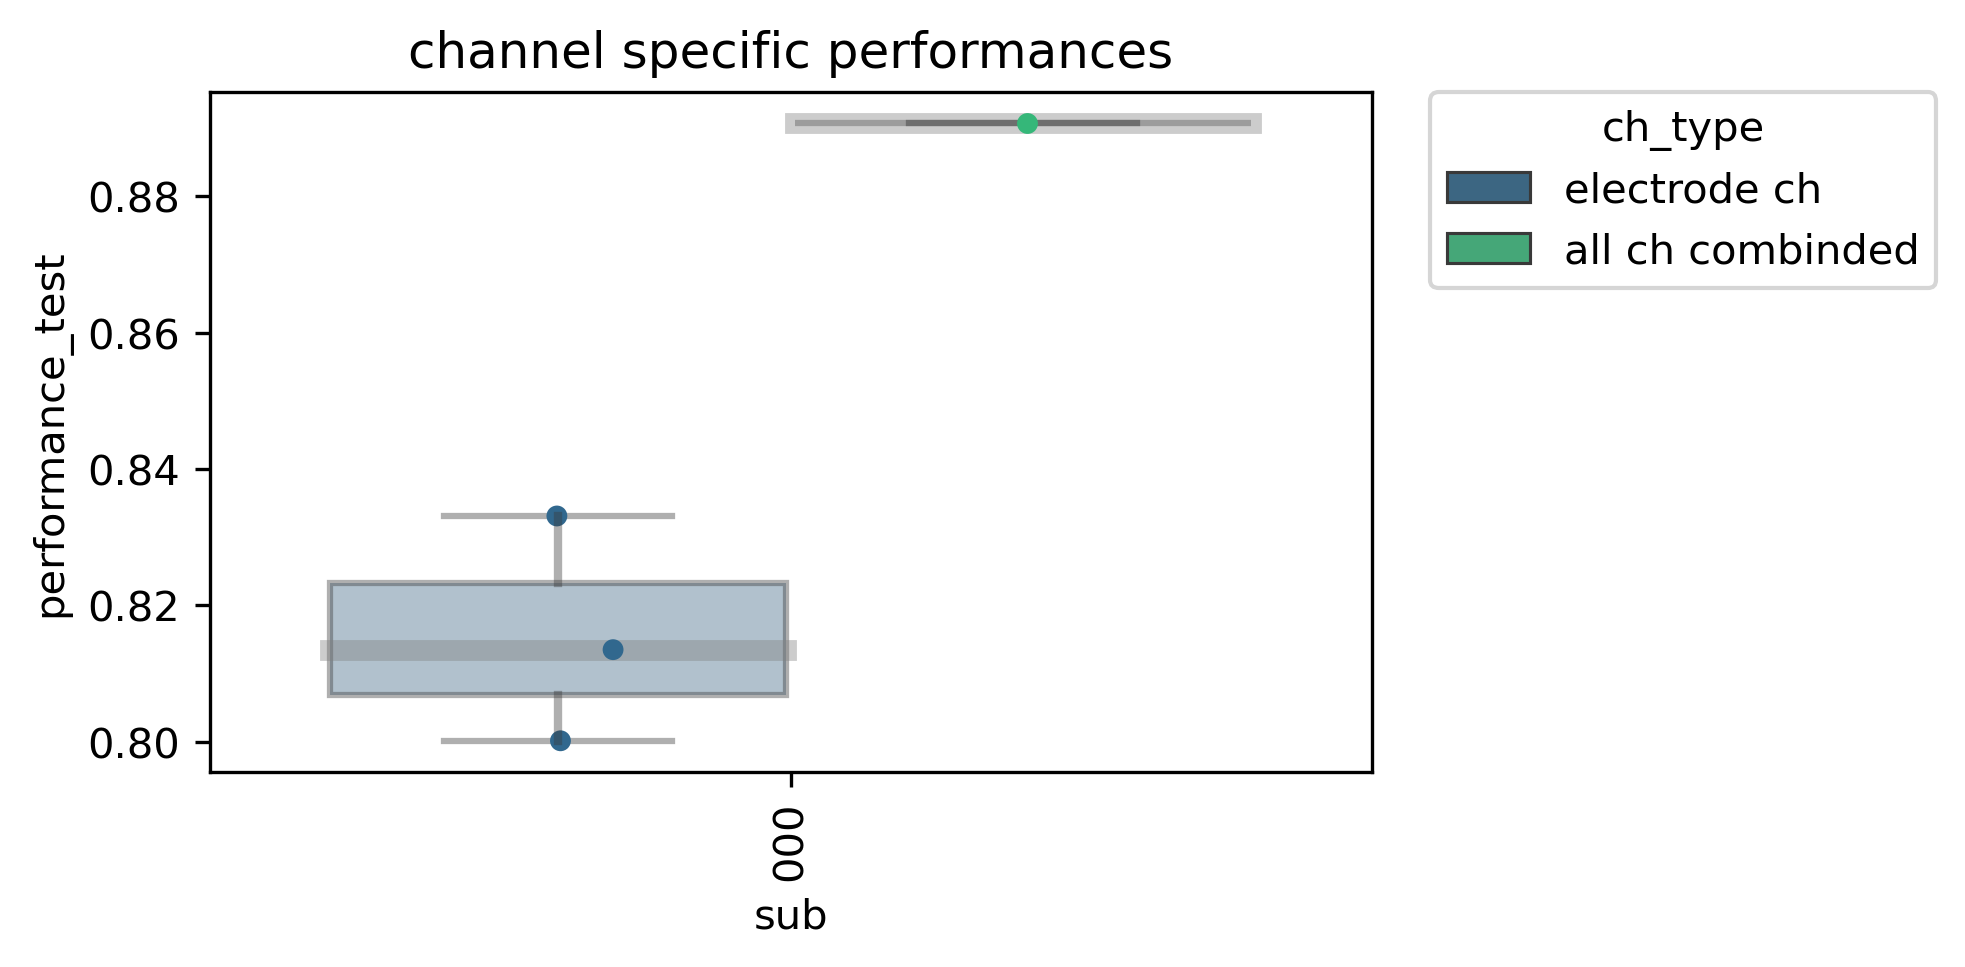

In [15]:
model = xgboost.XGBClassifier(use_label_encoder=False)


feature_reader_quantilePost.decoder = nm_decode.Decoder(
    features=feature_reader_quantilePost.feature_arr,
    label=feature_reader_quantilePost.label,
    label_name=feature_reader_quantilePost.label_name,
    used_chs=feature_reader_quantilePost.used_chs,
    model=model,
    eval_method=metrics.balanced_accuracy_score,
    cv_method=model_selection.KFold(n_splits=3, shuffle=True),
    get_movement_detection_rate=True,
    min_consequent_count=2,
    TRAIN_VAL_SPLIT=False,
    RUN_BAY_OPT=False,
    use_nested_cv=False,
    sfreq=feature_reader_quantilePost.settings["sampling_rate_features_hz"],
)

performances_quantilePost = feature_reader_quantilePost.run_ML_model(
    estimate_channels=True,
    estimate_gridpoints=False,
    estimate_all_channels_combined=True,
    save_results=True,
)

df_per_quantilePost = feature_reader_quantilePost.get_dataframe_performances(performances_quantilePost)

nm_plots.plot_df_subjects(
    df_per_quantilePost, x_col="sub", y_col="performance_test", hue="ch_type",
    PATH_SAVE=os.path.join(PATH_OUT_ZSCORE_POST, RUN_NAME, RUN_NAME + "_decoding_performance_quantilePost.png")
)

#### References
[1] Quantile normalization, https://en.wikipedia.org/wiki/Quantile_normalization